<a href="https://colab.research.google.com/github/aladinor/notebooks/blob/origin%2Fmaster/ATMS_406_HW3_MJO_ENSO_ALR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATMS 406 Homework 3

In this homework, you will use the Australian Bureau of Meteorology realtime Madden-Julian Oscillation index, the NCEP Multivariate El Nino-Southern Oscillation Index, and selected fields from the NCEP reanalysis to (1) examine the co-variability of the MJO and ENSO, (2) examine MJO-variability across the tropics for normalized index amplitudes > 1.  We'll analyze the period from 1979-2022 in this assignments.

Run the cell below; kernel will restart (crash).  Then run the next cell.

In [ ]:
!pip install -q condacolab pydap
import condacolab
condacolab.install()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:22
🔁 Restarting kernel...


Then, run this cell to install the appropriate software to create maps with `cartopy`.

In [ ]:
!mamba install -q -c conda-forge cartopy


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.0.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

  Package                  Version  Build                Channel                   Size
──────────────────────────

Import libraries to plot, load the data, and make maps.

In [ ]:
# import necessary packages
%pylab inline
# loads numpy, matplotlib
import xarray as xr
# loads data in variety of formats including netcdf data
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd
import scipy.stats as stats
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Question 1

Read the MJO index values from here (http://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt) using `pandas`.  I saved them on the Atmospheric Sciences web server since the BOM blocks web downloads as of Feb 2023.

In [ ]:
#Download if necessary - uncomment
!curl -o rmm.74toRealtime.txt https://www.atmos.illinois.edu/~snesbitt/data/rmm.74toRealtime.txt

mjo_daily = pd.read_csv('rmm.74toRealtime.txt',delim_whitespace=True,header=1)

curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2240k  100 2240k    0     0  5539k      0 --:--:-- --:--:-- --:--:-- 5546k


In [ ]:
mjo_daily.columns = map(lambda each:each.strip(","), mjo_daily.columns)
mjo_daily.columns = map(lambda each:each.strip("."), mjo_daily.columns)

In [ ]:
mjo_daily['date'] = pd.to_datetime(mjo_daily[['year','month','day']])
mjo_daily = mjo_daily.set_index('date')['1979-1-1':'2023-2-1']

In [ ]:
mjo_daily.head(5)

,year,month,day,RMM1,RMM2,phase,amplitude,Missing,Value=,1.E36,or,999
date,,,,,,,,,,,,
1979-01-01,1979,1,1,0.142507,1.05047,6,1.06009,Final_value:__OLR_&_NCEP_winds,NaN,NaN,NaN,NaN
1979-01-02,1979,1,2,-0.204200,1.37361,7,1.38870,Final_value:__OLR_&_NCEP_winds,NaN,NaN,NaN,NaN
1979-01-03,1979,1,3,-0.158610,1.53943,7,1.54758,Final_value:__OLR_&_NCEP_winds,NaN,NaN,NaN,NaN
1979-01-04,1979,1,4,-0.182450,1.45972,7,1.47108,Final_value:__OLR_&_NCEP_winds,NaN,NaN,NaN,NaN
1979-01-05,1979,1,5,-0.320050,1.13680,7,1.18100,Final_value:__OLR_&_NCEP_winds,NaN,NaN,NaN,NaN


Let's resample the daily index to monthly, taking the mean of the monthly amplitude and the mode of the phase.

In [ ]:
mjo_monthly = mjo_daily.resample("MS").apply({'amplitude':'mean','phase':lambda x: stats.mode(x)[0]})
mjo_monthly

<ipython-input-7-761263269e7e>:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mjo_monthly = mjo_daily.resample("MS").apply({'amplitude':'mean','phase':lambda x: stats.mode(x)[0]})


,amplitude,phase
date,,
1979-01-01,1.719532,7
1979-02-01,1.063415,3
1979-03-01,1.389601,4
1979-04-01,1.844991,1
1979-05-01,1.677857,4
...,...,...
2022-10-01,1.333969,7
2022-11-01,1.230573,7
2022-12-01,1.194990,4


In [ ]:
df= mjo_daily[mjo_daily['amplitude'] > 1]

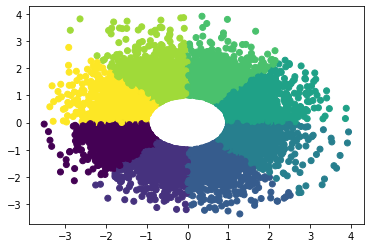

In [ ]:
plt.scatter(df['RMM1'], df['RMM2'], c=df['phase'], cmap='viridis')

(a) What is the relative frequency of the number of months in each MJO phase?

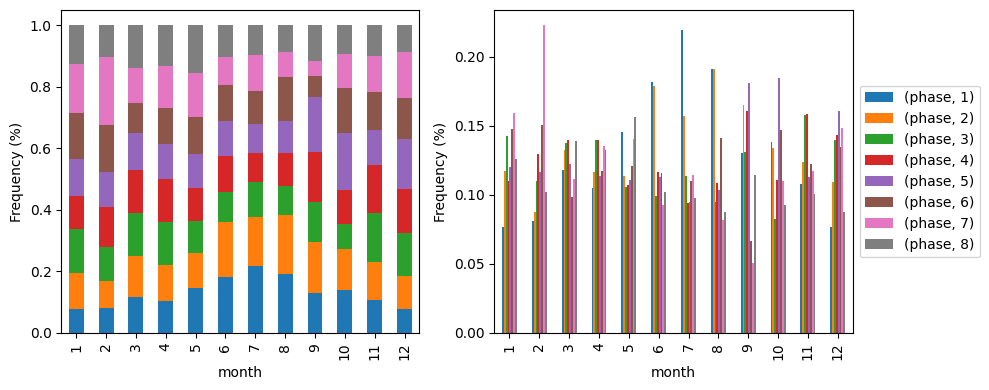

In [ ]:
rel_freq = mjo_daily.groupby(['month', 'phase']).agg({'phase': 'size'}).div(mjo_daily.groupby(['month']).agg({'phase': 'size'}))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
rel_freq.unstack().plot(kind='bar', stacked=True, ax=ax1, legend=False)
rel_freq.unstack().plot(kind='bar', ax=ax2).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.set_ylabel('Frequency (%)')
ax2.set_ylabel('Frequency (%)')
plt.tight_layout()

(b) What is the fraction of MJO events in each phase where the amplitude is > 1.0 normalized units?

In [ ]:
mjo_daily['amp_norm'] = mjo_daily[['phase', 'amplitude']].groupby('phase').apply(lambda x: (x - x.mean()) / x.std())['amplitude'] # Normalization x - mean / std

In [ ]:
fraction = mjo_daily[['phase', 'amplitude', 'amp_norm']].where(mjo_daily['amp_norm'] > 1).groupby(['phase']).size().div(mjo_daily[['phase', 'amplitude']].groupby(['phase']).size()) * 100
fraction

phase
1.0    16.035951
2.0    16.735254
3.0    16.290984
4.0    15.649606
5.0    15.832929
6.0    15.991903
7.0    16.112790
8.0    17.807457
dtype: float64

(c) Using the Wheeler and Hendon publication here: Wheeler, Matthew C., and Harry H. Hendon, 2004: An All-Season Real-Time Multivariate MJO Index: Development of an Index for Monitoring and Prediction, Monthly Weather Review, 132, 1917-1932, can you interpret which zonal region of the tropics has the highest amplitudes of this index?

Accordinto tho the fraction estimated previuosly, phase 8 has the highest amplitude located at western emiphere and Africa

## Question 2

Now, let's read the NCEP ENSO Index into `pandas`.

In [ ]:
enso = pd.read_csv('https://www.psl.noaa.gov/psd/data/correlation/censo.data',delim_whitespace=True,header=None,skiprows=1,skipfooter=2)
enso

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1948,0.26,0.43,0.72,0.21,0.24,0.41,0.08,0.25,0.45,-0.64,-0.21,0.58
1,1949,0.18,0.14,-0.55,0.15,0.43,0.00,-0.06,0.08,-0.42,-0.59,-0.29,-0.91
2,1950,-0.74,-1.71,-1.43,-1.29,-1.22,-1.69,-1.69,-0.96,-0.95,-1.27,-1.12,-1.61
3,1951,-1.13,-0.69,-0.24,0.33,0.71,0.19,1.33,1.01,1.10,1.15,0.91,0.83
4,1952,0.64,0.56,0.07,0.71,-0.50,-0.74,-0.54,-0.12,-0.03,-0.06,-0.02,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2018,-1.12,-0.14,-1.45,-0.49,-0.26,0.31,0.20,0.45,1.07,0.24,0.62,-0.23
71,2019,0.36,1.57,0.92,0.72,1.15,0.83,0.80,0.22,0.99,0.66,1.07,0.73
72,2020,0.20,0.30,0.52,0.48,-0.42,-0.02,-0.44,-1.28,-1.24,-1.19,-1.19,-1.86
73,2021,-1.87,-1.84,-0.55,-0.42,-0.45,-0.25,-1.05,-0.73,-0.70,-1.04,-1.14,-1.60


In [ ]:
enso_new=pd.DataFrame()
enso_new['Date']=pd.date_range(start=pd.datetime(1948,1,1),end=pd.datetime(2022,12,1),freq="MS")

enso_new = enso_new.set_index('Date')

enso_new['ENSO']=enso.loc[:,1:].stack().values
enso_new = enso_new['1948-1-1':'2022-12-31']

all_df = pd.merge(enso_new,mjo_monthly,left_index=True, right_index=True)

<ipython-input-14-b95a3171607a>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  enso_new['Date']=pd.date_range(start=pd.datetime(1948,1,1),end=pd.datetime(2022,12,1),freq="MS")


In [ ]:
all_df

,ENSO,amplitude,phase
1979-01-01,0.26,1.719532,7
1979-02-01,-0.25,1.063415,3
1979-03-01,0.32,1.389601,4
1979-04-01,0.47,1.844991,1
1979-05-01,-0.18,1.677857,4
...,...,...,...
2022-08-01,-1.52,0.952217,2
2022-09-01,-1.87,0.386766,5
2022-10-01,-1.78,1.333969,7
2022-11-01,-0.62,1.230573,7


(a) Is there a relationship between MJO phase occurrence frequency and the ENSO index? (i.e., what is the frequency of occurrence of MJO phases in ENSO index > 0.5 (El Nino), neutral (-0.5 to 0.5), 0 and < -0.5 (La Nina)?)

I suggest creating a dataframe with the frequencies in each category, and then plotting a heatmap (https://seaborn.pydata.org/generated/seaborn.heatmap.html)

In [ ]:
nino = all_df[all_df['ENSO'] >0.5]
nina = all_df[all_df['ENSO'] <-0.5]
neutral = all_df[(all_df['ENSO'] >= -0.5) & (all_df['ENSO'] <= 0.5)]

In [ ]:
nino_index = nino.groupby('phase').agg({'phase': {'size'}}).div(nino.groupby('phase').size().sum())

In [ ]:
nina_index = nina.groupby('phase').agg({'phase': {'size'}}).div(nina.groupby('phase').size().sum())


In [ ]:
neutral_index = neutral.groupby('phase').agg({'phase': {'size'}}).div(neutral.groupby('phase').size().sum())

[Text(33.0, 0.5, 'MJO Phase'), Text(0.5, 15.0, 'ENSO')]

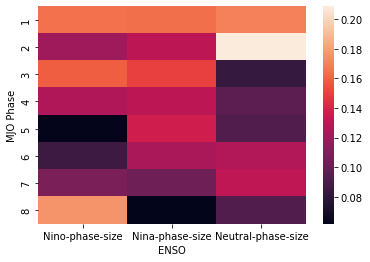

In [ ]:
_ = ['Nino', 'Nina', 'Neutral']
df_all = pd.concat([nino_index, nina_index, neutral_index], axis=1, keys=_, levels=[_] )
ax = sns.heatmap(df_all)
ax.set(xlabel="ENSO", ylabel="MJO Phase")

(b) Physically, why or why not would you expect the relationship you found in (a), or the lack thereof, to be the case?

ENSO is a longer time phenomena than MJO. Therefore, MJO occours while ENSO in in the backgroud. This can lead into a relationship between MJO and ENSO phenomena. If we look long-time period MJO at each ENSO state (Niño, Niña, and Neutral) there are up to 20% of frequency of a MJO given phase within each ENSO state. I think this should be analyzed in a short-time period to see if there is constructive or destructive patterns with MJO and ENSO wave interaction.

## Question 3

You can access the NCEP Reanalysis 1 data through commands below in order to answer this question.  The variables loaded below are u- and v-wind at 200 hPa, skin temperature, and precipitation.  We will cut the latitude band to the tropics and subtopics to save time using the `sel` command.

In [ ]:
import xarray as xr

uwnd=xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/uwnd.mon.mean.nc', engine='pydap').sel(level=200, time=slice('1979-1-1','2022-12-31'), lat=slice(50,-50))
vwnd=xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/vwnd.mon.mean.nc', engine='pydap').sel(level=200, time=slice('1979-1-1','2022-12-31'), lat=slice(50,-50))

In [ ]:
skt=xr.open_dataset('http://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/skt.mon.mean.nc', engine='pydap').sel(time=slice('1979-1-1','2022-12-31'), lat=slice(50,-50))
prec=xr.open_dataset('http://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/prate.sfc.mon.mean.nc', engine='pydap').sel(time=slice('1979-1-1','2022-12-31'), lat=slice(50,-50))

The code below creates a climatology by month for the variable `skt`.  It then calculates anomalies for each month in the data record

In [ ]:
skt_clim = skt.groupby('time.month').mean('time')
skt_anom = skt.groupby('time.month') - skt_clim

Look at this El Nino!

/usr/local/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


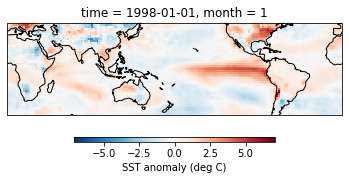

In [ ]:
p = skt_anom['skt'].sel(time='1998-01-01').plot(subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=180), facecolor="gray"),
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'orientation':'horizontal','shrink':0.6, 'pad': 0.1, 'aspect':40, 'label':'SST anomaly (deg C)'})

p.axes.coastlines();

(a) Calculate the monthly anomalies of skin temperature (sea surface temperature), precipitation, 200 hPa u-wind and v-wind anomalies relative to the long term mean monthly anomaly of each variable.  That is, values from January should be subtracted from the January long term mean file, etc.

In [ ]:
# Monthly anomalies of temperature
skt_clim = skt.groupby('time.month').mean('time')
skt_anom = skt.groupby('time.month') - skt_clim


In [ ]:
# Monthly anomalies of precipitation
pp_clim = prec.groupby('time.month').mean('time')
pp_anom = prec.groupby('time.month') - pp_clim


In [ ]:
# Monthly anomalies of 200 hPa u-wind
uw_clim = uwnd.groupby('time.month').mean('time')
uw_anom = uwnd.groupby('time.month') - uw_clim


In [ ]:
# Monthly anomalies of 200 hPa v-wind
vw_clim = vwnd.groupby('time.month').mean('time')
vw_anom = vwnd.groupby('time.month') - vw_clim

(b) Calculate and plot a `cartopy` map containing 8 panels: the mean precipitation anomalies (shaded), skin temperature anomalies (contoured) and 200 hPa wind vector anomalies for the 8 phases of the MJO where the MJO amplitude is $\ge$ 1.

Hint:  I've given you a working example using the `groupby` function in xarray that you can use to group times with coordinate values calculated from the MJO time series.  Then you can use the `.mean(time)` command to make composites for each of those collections.

You'll have to figure out how to

In [ ]:
#put the phase dataset into the NCEP reanalysis, with consistent coordinates
skt_anom['phase']=xr.DataArray(all_df['phase'],dims='time',coords={'time':skt_anom.time})
skt_anom['amplitude']=xr.DataArray(all_df['amplitude'],dims='time',coords={'time':skt_anom.time})
skt_anom_gt1 = skt_anom.where(skt_anom['amplitude'] >= 1, drop=True)
# perform the groupby operation
skt_phase = skt_anom.groupby('phase').mean('time')
skt_phase

<xarray.Dataset>
Dimensions:    (lon: 192, lat: 52, phase: 8)
Coordinates:
  * lon        (lon) float32 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float32 48.57 46.67 44.76 42.86 ... -44.76 -46.67 -48.57
  * phase      (phase) int64 1 2 3 4 5 6 7 8
Data variables:
    skt        (phase, lat, lon) float32 0.08428 0.1289 ... -0.1072 -0.0892
    amplitude  (phase) float64 1.226 1.235 1.333 1.148 1.252 1.336 1.328 1.358

In [ ]:
## precipitaion anomaly and phase
pp_anom['phase'] = xr.DataArray(all_df['phase'], dims='time', coords={'time':skt_anom.time})
pp_anom['amplitude'] = xr.DataArray(all_df['amplitude'], dims='time', coords={'time':skt_anom.time})
pp_anom_gt1 = pp_anom.where(pp_anom['amplitude'] >= 1, drop=True)
pp_phase = pp_anom.groupby('phase').mean('time')

In [ ]:
# uwind anomaly and phase
uw_anom['phase'] = xr.DataArray(all_df['phase'], dims='time', coords={'time':skt_anom.time})
uw_anom['amplitude'] = xr.DataArray(all_df['amplitude'], dims='time', coords={'time':skt_anom.time})
uw_anom_gt1 = uw_anom.where(pp_anom['amplitude'] >= 1, drop=True)
uw_phase = uw_anom.groupby('phase').mean('time')
uw_phase

<xarray.Dataset>
Dimensions:    (lon: 144, lat: 41, phase: 8)
Coordinates:
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 50.0 47.5 45.0 42.5 ... -42.5 -45.0 -47.5 -50.0
  * phase      (phase) int64 1 2 3 4 5 6 7 8
Data variables:
    uwnd       (phase, lat, lon) float32 1.044 1.055 1.043 ... 0.04137 0.03355
    amplitude  (phase) float64 1.226 1.235 1.333 1.148 1.252 1.336 1.328 1.358

In [ ]:
# vwind anomaly and phase
vw_anom['phase'] = xr.DataArray(all_df['phase'], dims='time', coords={'time':skt_anom.time})
vw_anom['amplitude'] = xr.DataArray(all_df['amplitude'], dims='time', coords={'time':skt_anom.time})
vw_anom_gt1 = vw_anom.where(pp_anom['amplitude'] >= 1, drop=True)
vw_phase = vw_anom.groupby('phase').mean('time')
vw_phase

<xarray.Dataset>
Dimensions:    (lon: 144, lat: 41, phase: 8)
Coordinates:
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 50.0 47.5 45.0 42.5 ... -42.5 -45.0 -47.5 -50.0
  * phase      (phase) int64 1 2 3 4 5 6 7 8
Data variables:
    vwnd       (phase, lat, lon) float32 0.82 0.6042 0.3587 ... 0.1972 0.155
    amplitude  (phase) float64 1.226 1.235 1.333 1.148 1.252 1.336 1.328 1.358

In [ ]:
uv_wind_anom = vw_phase
uv_wind_anom['uwnd'] = uw_phase['uwnd']
uv_wind_anom

<xarray.Dataset>
Dimensions:    (lon: 144, lat: 41, phase: 8)
Coordinates:
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 50.0 47.5 45.0 42.5 ... -42.5 -45.0 -47.5 -50.0
  * phase      (phase) int64 1 2 3 4 5 6 7 8
Data variables:
    vwnd       (phase, lat, lon) float32 0.82 0.6042 0.3587 ... 0.1972 0.155
    amplitude  (phase) float64 1.226 1.235 1.333 1.148 1.252 1.336 1.328 1.358
    uwnd       (phase, lat, lon) float32 1.044 1.055 1.043 ... 0.04137 0.03355

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['quiver']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
<ipython-input-33-345e7e8bde6e>:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


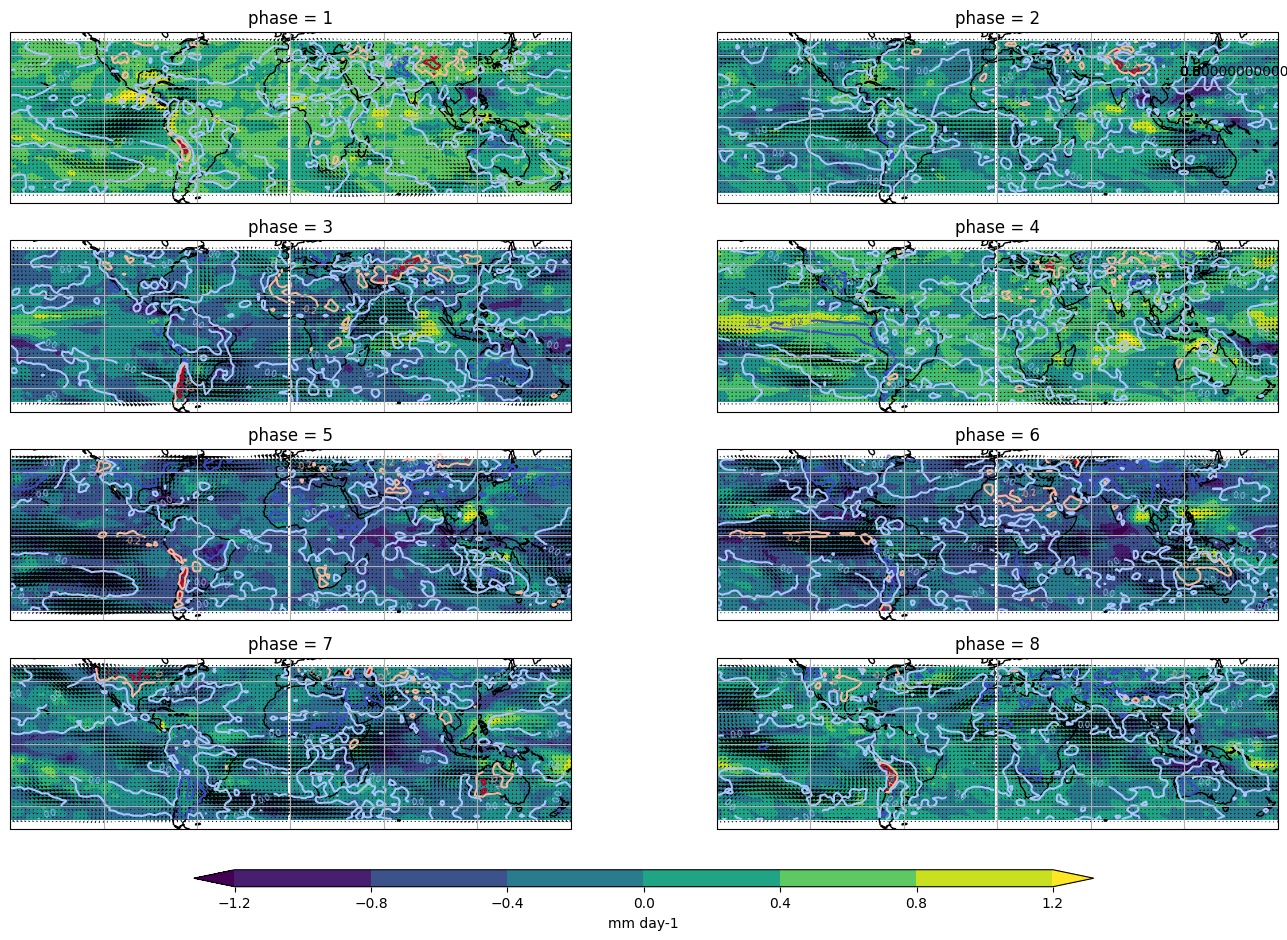

In [ ]:
%pylab inline
import cartopy.crs as ccrs
nrows = 4
ncols = 2

clevs=np.arange(40)
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
subplot_kw={'projection': ccrs.PlateCarree()},
figsize=(15,8.5), dpi=100)

for idx, ax in enumerate(axs.flatten()):
  idx += 1
  # precipitation anomaly
  cs = ax.contourf(pp_phase['lon'], pp_phase['lat'],
             pp_phase['prate'].sel(phase=idx) * 86400,
             transform = ccrs.PlateCarree(),
             cmap='viridis',extend='both')
  ## temp anomaly
  cs2 = ax.contour(skt_phase['lon'], skt_phase['lat'],
             skt_phase['skt'].sel(phase=idx),
             levels=np.arange(-0.5, 0.5, 0.25),
             transform = ccrs.PlateCarree(),
             extend='both',
             cmap='coolwarm_r')

  # wind anomaly
  ax.clabel(cs2, fmt='%.1f', fontsize=6)
  ax.coastlines()
  ax.gridlines()
  ax.set_title(f"Phase {idx}")

  quiver = uv_wind_anom.sel(phase=idx).plot.quiver(x='lon', y='lat',
                                                   u='uwnd', v='vwnd',
                              transform=ccrs.PlateCarree(),scale=200, ax=ax)

# precip anomalies cbar
cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='mm day-1')
plt.tight_layout()
